In [1]:
import h5py
import os
import matplotlib.pyplot as plt
import llama.plotting.plotters as p
import llama.api.options as opts
import numpy as np
from importlib import reload
import llama
from llama.dev_utils import reload_module_recursively
import copy
from llama.io.loaders.xrf.api import load_data_from_xrf_format

In [2]:
# Load the XRF data
folder = "/net/micdata/data3/hruth/xrf_data/Tomo-3-new/"
xrf_standard_data_dict = load_data_from_xrf_format(folder)

100%|██████████| 93/93 [00:16<00:00,  5.53it/s]


In [34]:
os.listdir(folder)

['2xfm_0620.mda.h5',
 '2xfm_0621.mda.h5',
 '2xfm_0622.mda.h5',
 '2xfm_0623.mda.h5',
 '2xfm_0624.mda.h5',
 '2xfm_0625.mda.h5',
 '2xfm_0626.mda.h5',
 '2xfm_0627.mda.h5',
 '2xfm_0628.mda.h5',
 '2xfm_0629.mda.h5',
 '2xfm_0630.mda.h5',
 '2xfm_0631.mda.h5',
 '2xfm_0632.mda.h5',
 '2xfm_0633.mda.h5',
 '2xfm_0634.mda.h5',
 '2xfm_0635.mda.h5',
 '2xfm_0636.mda.h5',
 '2xfm_0637.mda.h5',
 '2xfm_0638.mda.h5',
 '2xfm_0639.mda.h5',
 '2xfm_0640.mda.h5',
 '2xfm_0641.mda.h5',
 '2xfm_0642.mda.h5',
 '2xfm_0643.mda.h5',
 '2xfm_0644.mda.h5',
 '2xfm_0645.mda.h5',
 '2xfm_0646.mda.h5',
 '2xfm_0647.mda.h5',
 '2xfm_0648.mda.h5',
 '2xfm_0649.mda.h5',
 '2xfm_0650.mda.h5',
 '2xfm_0651.mda.h5',
 '2xfm_0652.mda.h5',
 '2xfm_0653.mda.h5',
 '2xfm_0654.mda.h5',
 '2xfm_0655.mda.h5',
 '2xfm_0656.mda.h5',
 '2xfm_0657.mda.h5',
 '2xfm_0658.mda.h5',
 '2xfm_0659.mda.h5',
 '2xfm_0660.mda.h5',
 '2xfm_0661.mda.h5',
 '2xfm_0662.mda.h5',
 '2xfm_0663.mda.h5',
 '2xfm_0664.mda.h5',
 '2xfm_0665.mda.h5',
 '2xfm_0666.mda.h5',
 '2xfm_0667.m

In [35]:
F = h5py.File(os.path.join(folder, '2xfm_0699.mda.h5'), "r")

In [3]:
# Convert the XRF data into a dictionary of arrays, where each
# dictionary key corresponds to a channel
from llama.io.loaders.xrf.api import convert_xrf_projection_dicts_to_arrays
xrf_array_dict = convert_xrf_projection_dicts_to_arrays(
    xrf_standard_data_dict,
    pad_with_mode=True,
)

Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1064.51it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1114.75it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1140.25it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1177.39it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1164.45it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1173.75it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1135.77it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1102.66it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1140.58it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1161.35it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1124.07it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1149.77it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1149.29it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1166.42it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1138.41it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1145.54it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1133.16it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1091.82it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1095.37it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1079.14it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1111.49it/s]


Fixing projections dimensions...Completed
Projection array shape: [128 448]
Fixing projections dimensions...


100%|██████████| 93/93 [00:00<00:00, 1059.31it/s]

Fixing projections dimensions...Completed


In [4]:
# Insert the data into an XRFTask object
from llama.data_structures.xrf_object import XRFTask
# Just use angles from the first one
k = "Al"
xrf_task = XRFTask(
    xrf_array_dict=xrf_array_dict,
    angles=xrf_standard_data_dict[k].angles,
    scan_numbers=xrf_standard_data_dict[k].scan_numbers,
    task_options=opts.AlignmentTaskOptions(),
    projection_options=opts.ProjectionOptions(),
    primary_channel="Total_Fluorescence_Yield",
)
# The primary_channel designates which channel of data is used in alignment calculations.
# This can be changed at any time.

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 29.16it/s]


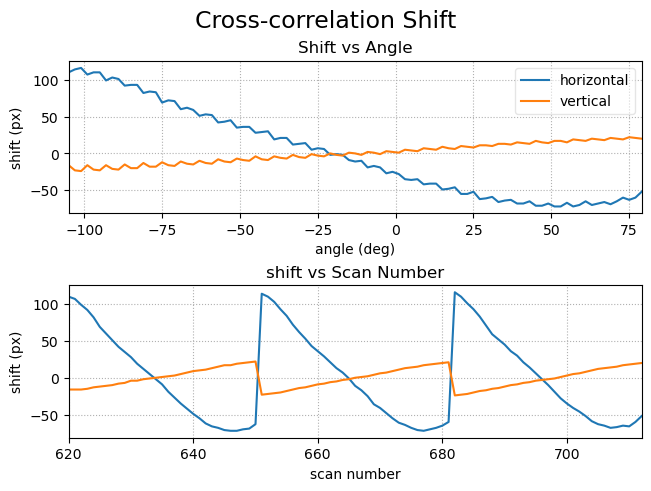

Cross-correlation shift stored in shift_manager


In [7]:
# Update cross-correlation options and run the alignment
xrf_task.task_options.cross_correlation = opts.CrossCorrelationOptions(
    iterations=10,
    binning=1,
    filter_position=11,
    filter_data=0.005,
    precision=0.01,
    remove_slow_variation=False,
)
xrf_task.get_cross_correlation_shift()

100%|██████████| 10/10 [00:00<00:00, 29.08it/s]


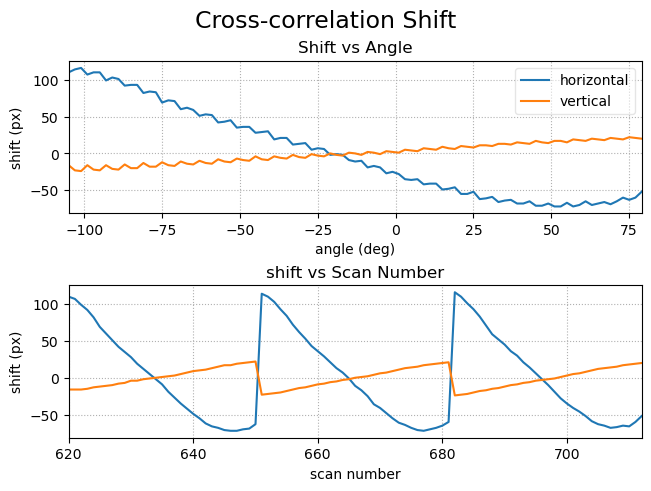

Cross-correlation shift stored in shift_manager


In [6]:
# Update cross-correlation options and run the alignment
xrf_task.task_options.cross_correlation = opts.CrossCorrelationOptions(
    iterations=10,
    binning=1,
    filter_position=10,
    filter_data=0.005,
    precision=0.01,
    remove_slow_variation=False,
)
xrf_task.get_cross_correlation_shift()

In [ ]:
# Plot the results
%matplotlib widget
sort_idx = np.argsort(xrf_task.angles)
xrf_task.plot_alignment_results(["Total_Fluorescence_Yield"], sort_idx = sort_idx)

In [10]:
# Finally, apply the cross-correlation_shift
xrf_task.apply_staged_shift_to_all_channels()

In [ ]:
print(list(xrf_task.channels))

['Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Ti', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'COMPTON_AMPLITUDE', 'COHERENT_SCT_AMPLITUDE', 'Num_Iter', 'Fit_Residual', 'Total_Fluorescence_Yield', 'Sum_Elastic_Inelastic']


In [ ]:
plot_options = opts.ImageSliderPlotOptions(image=opts.PlotDataOptions(colorbar=True))
xrf_task.plot_xrf_channels(
    channels=["Total_Fluorescence_Yield", "Al", "Si"],
    plot_options=plot_options,
    subplot_dims=(3, 1),
)

## get 3D reconstruction

In [101]:
xrf_task.projections_dict[xrf_task.primary_channel].options.experiment.sample_thickness = 500
xrf_task.projections_dict[xrf_task.primary_channel].options.experiment.laminography_angle = 45
xrf_task.projections_dict[xrf_task.primary_channel].center_of_rotation[1] = 240
print(xrf_task.projections_dict[xrf_task.primary_channel].reconstructed_object_dimensions)

pinned_data = llama.gpu_utils.create_empty_pinned_array_like(
    xrf_task.projections_dict[xrf_task.primary_channel].data
)
xrf_task.projections_dict[xrf_task.primary_channel].get_3D_reconstruction()#True, pinned_data)

[317 317 500]


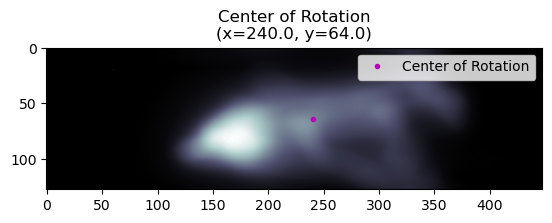

In [94]:
xrf_task.projections_dict[xrf_task.primary_channel].center_of_rotation[1] = 240
plt.figure()
xrf_task.projections_dict[xrf_task.primary_channel].show_center_of_rotation()
plt.show()

In [99]:
pinned_data = llama.gpu_utils.create_empty_pinned_array_like(
    xrf_task.projections_dict[xrf_task.primary_channel].data
)
xrf_task.projections_dict[xrf_task.primary_channel].get_3D_reconstruction()#True, pinned_data)

interactive(children=(IntSlider(value=0, description='index', max=499), Output()), _dom_classes=('widget-inter…

Play(value=0, description='Play', interval=500, max=499)

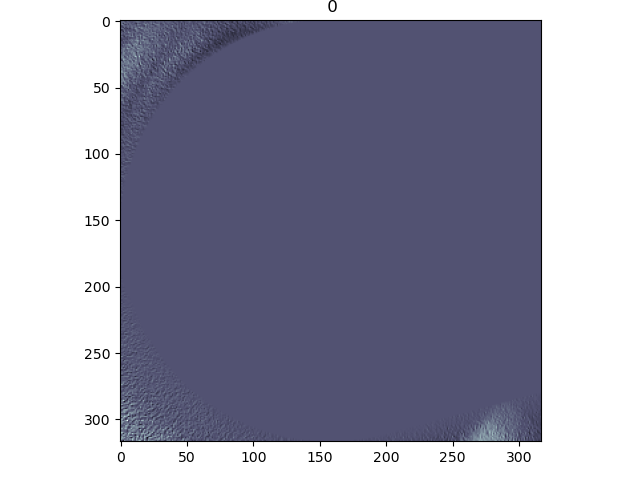

In [100]:
%matplotlib widget
from llama.plotting.plotters import ImagePlotObject, make_image_slider_plot

plot_options = opts.ImageSliderPlotOptions(slider=opts.SliderPlotOptions())
plot_object = ImagePlotObject(
    xrf_task.projections_dict[xrf_task.primary_channel].laminogram.data, options=plot_options
)
make_image_slider_plot([plot_object])

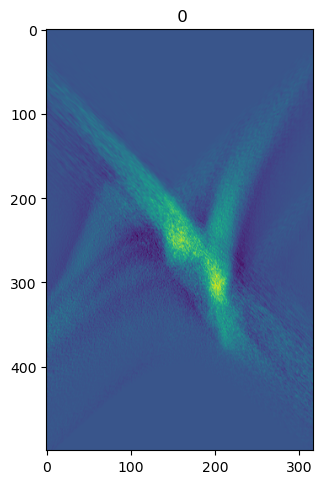

In [91]:
%matplotlib inline
plt.imshow(xrf_task.projections_dict[xrf_task.primary_channel].laminogram.data[:, :, 100])
plt.show()


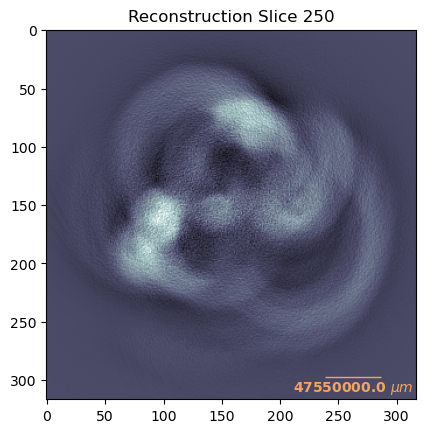

In [92]:
%matplotlib inline
xrf_task.projections_dict[xrf_task.primary_channel].laminogram.plot_data()

## you can also drop projections

In [ ]:
xrf_task.drop_projections_from_all_channels(remove_idx=[95, 96, 97, 98])

In [1]:
plot_options = opts.ImageSliderPlotOptions(image=opts.PlotDataOptions(colorbar=True))
xrf_task.plot_xrf_channels(
    channels=["Total_Fluorescence_Yield", "Al", "Si"],
    plot_options=plot_options,
    subplot_dims=(3, 1),
)

NameError: name 'opts' is not defined